## SAGA Paper 4, FIGURE 13:  Conformity

In [1]:
import numpy as np
from myplotstyle import plt, get_figsize

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from astropy.table import join
from collections import defaultdict

In [2]:
saga = SAGA.QuickStart()

SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())

# for this notebook
base = Query(C.sat_rcut, "p_sat_corrected > 0").filter(base)

nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
hosts = saga.host_catalog.load(include_stats=True, query="paper3")

hosts["nuv_ssfr"] = hosts["nuv_sfr"] - hosts["log_sm"]
hosts["qf_gold"] = hosts["sats_gold_quenched"] / hosts["sats_gold"]
hosts["qf_gold_silver"] = hosts["sats_gold_silver_quenched"] / hosts["sats_gold_silver"]

In [5]:
d = defaultdict(list)
for host in hosts["HOSTID"]:
    d["HOSTID"].append(host)

    sats_this = Query(C.is_sat, QueryMaker.equal("HOSTID", host)).filter(base)
    d["sat_gold_median_distance"].append(np.median(C.sample_gold.filter(sats_this, "RHOST_KPC")) if C.sample_gold.count(sats_this) else np.nan)

    sat_Mr = sats_this["Mr"]
    if len(sat_Mr) > 1:
        sat_Mr = np.sort(sat_Mr)
        gap = sat_Mr[1] - sat_Mr[0]
    else:
        gap = np.nan
    d["sat_gap"].append(gap)

hosts = join(hosts, d, "HOSTID")

In [6]:
def host_selection(*query, invert=False):
    return QueryMaker.isin("HOSTID", Query(*query).filter(hosts, "HOSTID"), invert=invert)

def select_host_quantiles(prop):
    qm = np.nanpercentile(hosts[prop], 50)
    return (
        host_selection(f"{prop} > {qm}"),
        host_selection(f"{prop} < {qm}"),
    )

In [7]:
column_labels = dict([
    ("K_ABS", "$M_K$"),
    ("M_HALO", "Group mass"),
    ("NEAREST_MASSIVE_DIST", "$d$ to nearest massive\nhost"),
    ("gr", "$g-r$"),
    ("ba", "$b/a$"),
    ("phi", "Position angle"),
    ("sb_r", "Surface\nBrightness"),
    ("SERSIC", "Sersic Index"),
    ("log_sm", "Stellar mass"),
    ("most_massive_sat", "Most massive sat\nstellar mass"),
    ("nuv_sfr", "NUV SFR"),
    ("nuv_ssfr", "NUV sSFR"),
    ("sat_gold_median_distance", "Median satellite\ndistance (Gold)"),
    ("sat_gap", "1st/2nd satellites\nmagnitude gap"),
    ("LOG_MHI", "HI mass"),
])

In [8]:
quenched_selector = Query("quenched_phony == 1")
star_forming_selector = Query("quenched_phony == 0")

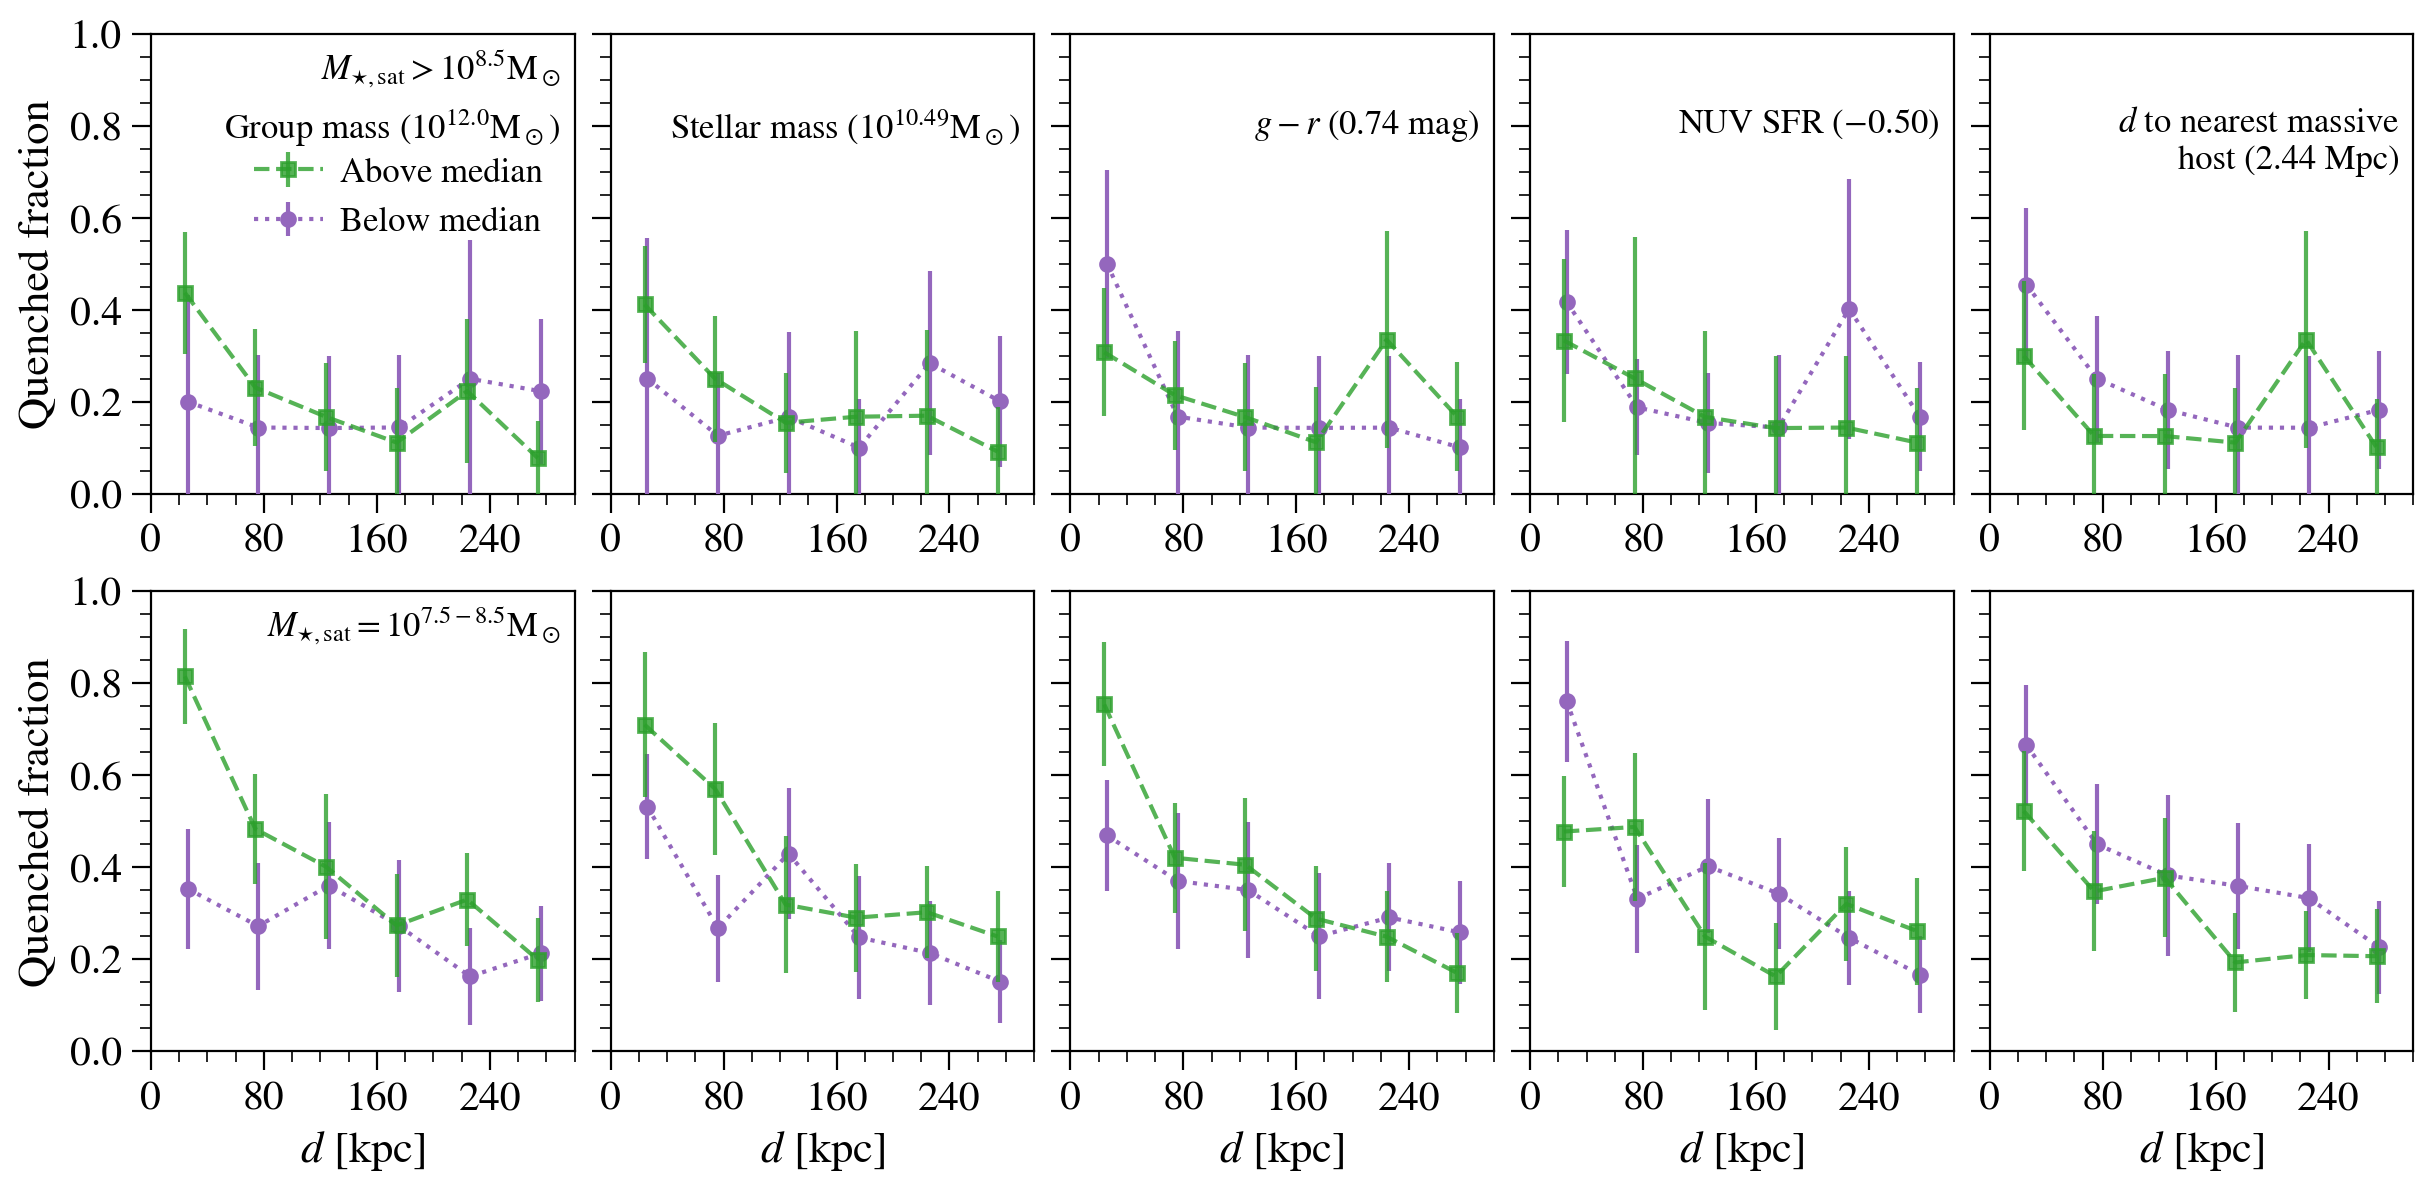

In [9]:
rbins = np.linspace(0, 300, 7)
x = 0.5 * (rbins[1:] + rbins[:-1])

sample_selector = C.sample_gold | C.sample_silver
base_sf = Query(sample_selector, star_forming_selector).filter(base, ["HOSTID", "log_sm_phony", "p_sat_corrected", "RHOST_KPC"])
base_q = Query(sample_selector, quenched_selector).filter(base, ["HOSTID", "log_sm_phony", "p_sat_corrected", "RHOST_KPC"])

row_queries = [
    Query("log_sm_phony >= 8.5"),
    Query("log_sm_phony >= 7.5", "log_sm_phony < 8.5"),
]

host_props = [  # key, median format
    ("M_HALO", r"$10^{{{:.1f}}} {{\rm M}}_\odot$"),
    ("log_sm", r"$10^{{{:.2f}}} {{\rm M}}_\odot$"),
    ("gr", r"{:.2f} mag"),
    ("nuv_sfr", r"${:.2f}$"),
    ("NEAREST_MASSIVE_DIST", r"{:.2f} Mpc"),
]

fig, ax = plt.subplots(len(row_queries), 5, figsize=get_figsize(wide=True, ratio=2.1),
                       sharex=False, sharey=True, gridspec_kw=dict(wspace=0))

for icol, (host_prop, median_format) in enumerate(host_props):
    host_median = np.nanpercentile(hosts[host_prop], 50)
    for j, (ax_row, q) in enumerate(zip(ax, row_queries)):
        ax_this = ax_row[icol]
        base_sf_ = q.filter(base_sf)
        base_q_ = q.filter(base_q)

        for i, host_selector in enumerate(select_host_quantiles(host_prop)):

            t = host_selector.filter(base_sf_)
            count_sf = np.histogram(t["RHOST_KPC"], rbins, weights=t["p_sat_corrected"])[0]

            t = host_selector.filter(base_q_)
            count_q = np.histogram(t["RHOST_KPC"], rbins, weights=t["p_sat_corrected"])[0]

            qf = (count_q + 1) / (count_sf + count_q + 2)
            qf_err = np.sqrt(qf * (1-qf) / (count_sf + count_q))

            qf = np.where(count_sf + count_q < 1, np.nan, qf)
            ax_this.errorbar(x+(i-0.5)*2, qf, qf_err, marker=("o" if i else "s"),
                             label=("Below median" if i else "Above median"),
                             c=("C4" if i else "C2"), ls=(":" if i else "--"),
                             zorder=(10-i), alpha=(1 if i else 0.8))

        if j == 0:
            ax_this.text(290, 0.84, column_labels[host_prop]+ " (" + median_format.format(host_median) + ")", ha="right", va="top", fontsize="small")
        if j == 1:
            ax_this.set_xlabel("$d$ [kpc]")
        if icol == 0:
            ax_this.set_ylabel("Quenched fraction")
        ax_this.set_ylim(0, 1)
        ax_this.set_yticks(np.linspace(0, 1, 6))
        ax_this.set_xlim(0, 300)
        ax_this.set_xticks([0, 80, 160, 240])

ax[0,0].text(290, 0.97, r"$M_{\star,{\rm sat}} > 10^{8.5} {\rm M}_\odot$", ha="right", va="top", fontsize="small")
ax[1,0].text(290, 0.97, r"$M_{\star,{\rm sat}} = 10^{7.5-8.5}  {\rm M}_\odot$", ha="right", va="top", fontsize="small")
ax[0,0].legend(loc="upper right", fontsize="small", bbox_to_anchor=(1, 0.8))

plt.savefig("figure_conform.pdf")

# Compare in more detail

SpearmanrResult(correlation=nan, pvalue=nan)


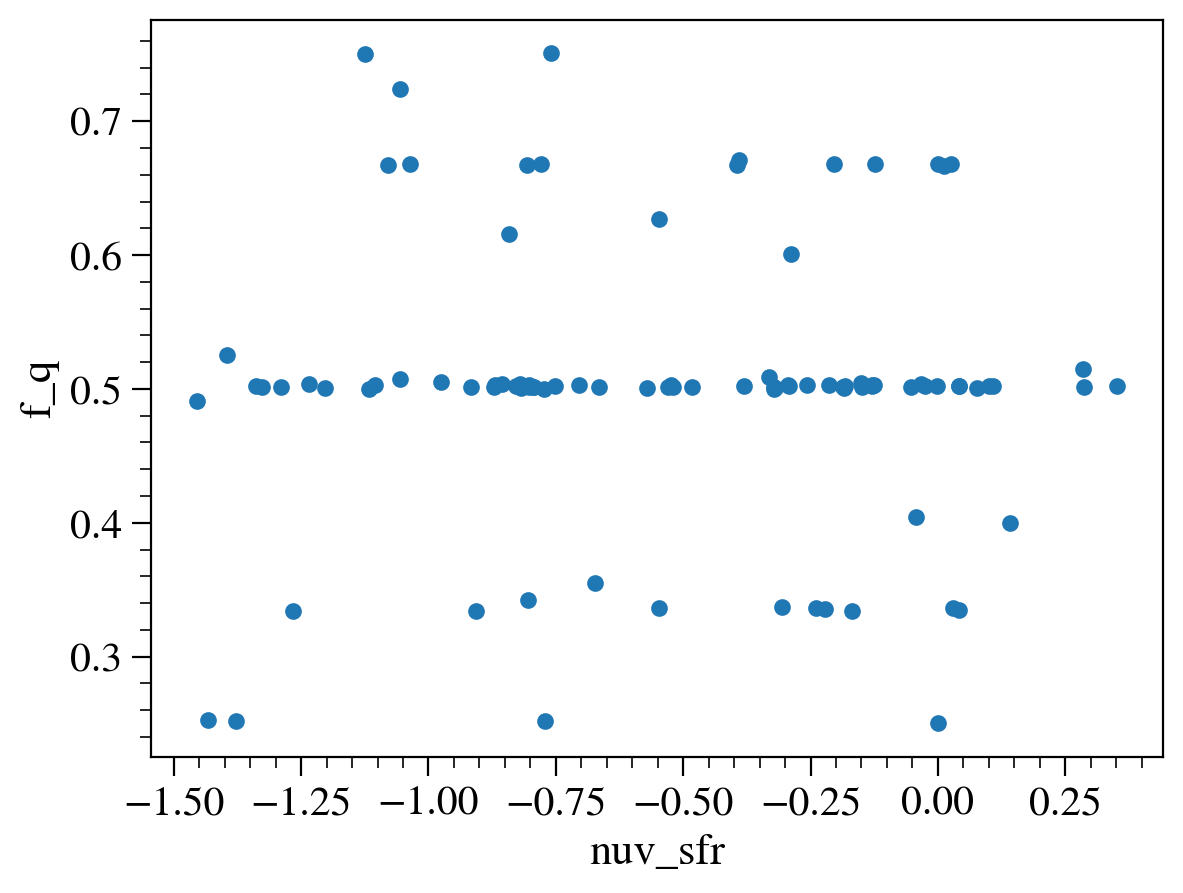

In [20]:
from scipy.stats import spearmanr

sats_query = Query("log_sm_phony >= 7.5", "log_sm_phony < 8.5", "RHOST_KPC < 100")
#sats_query = Query("log_sm_phony >= 7.5", "log_sm_phony < 8.5")
#sats_query = Query("log_sm_phony >= 8.5", "RHOST_KPC < 100")


#host_prop = "M_HALO"
#host_prop = "log_sm"
host_prop = 'gr'
host_prop='nuv_sfr'
#host_prop = "NEAREST_MASSIVE_DIST"

t = join(
    sats_query.filter(base_sf, ["HOSTID", "p_sat_corrected"]).group_by("HOSTID").groups.aggregate(np.sum),
    sats_query.filter(base_q, ["HOSTID", "p_sat_corrected"]).group_by("HOSTID").groups.aggregate(np.sum),
    keys="HOSTID",
    join_type="outer",
    table_names=["sf", "q"],
)
t["p_sat_corrected_sf"].fill_value = 0
t["p_sat_corrected_q"].fill_value = 0
t = t.filled()
t["fq"] = (t["p_sat_corrected_q"] + 1) / (t["p_sat_corrected_sf"] + t["p_sat_corrected_q"] + 2)

t = join(
    t["HOSTID", "fq"],
    hosts["HOSTID", host_prop],
    keys="HOSTID",
)

plt.scatter(t[host_prop], t["fq"])
plt.xlabel(host_prop)
plt.ylabel("f_q")
plt.axvline(np.median(t[host_prop]), c="C3", lw=0.5)


print(spearmanr(t[host_prop], t["fq"]))

In [ ]:
#M_HALO vs fq (ms=7.5-8.5, <100kpc), pvalue=0.0080
#M_HALO vs fq (ms=7.5-8.5),          pvalue=0.321
#M_HALO vs fq (ms=>8.5, <100kpc),    pvalue=0.48

#log_sm vs fq (ms=7.5-8.5, <100kpc), pvalue=0.0491
#log_sm vs fq (ms=7.5-8.5,),         pvalue=0.7
 
#NEAREST_MASSIVE_DIST vs fq (ms=7.5-8.5, <100kpc), pvalue=0.392
#NEAREST_MASSIVE_DIST vs fq (ms=7.5-8.5),          pvalue=0.298
#NEAREST_MASSIVE_DIST vs fq (ms>=7.5),             pvalue=0.364